In [1]:
# Read data
# ==============================================================================
import glob
import warnings

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [2]:
# Load data
# =============================================================================
parameter_name_wind = "fu3010z0"
station_name = "COM"

data_all = pd.concat(
    [
        pd.read_csv(file, sep=";", encoding="latin-1")
        for file in glob.glob("./data/*-VQHA80.csv")
    ]
)

data_all["Date"] = pd.to_datetime(data_all["Date"], format="%Y%m%d%H%M")
data_all = data_all.set_index("Date")

data_station = data_all[data_all["Station/Location"] == station_name]

data_station = data_station.sort_index()
data_station = data_station[~data_station.index.duplicated()]
data_station = data_station.drop(data_station[data_station[parameter_name_wind] == "-"].index)
data_station[parameter_name_wind] = data_station[parameter_name_wind].astype(float)
data_station = data_station.asfreq("600S", method="bfill")
data_station = data_station[parameter_name_wind]

start_train_date = "2023-09-11 06:50:00"
end_train_date = "2023-09-19 09:50:00"

data_train = data_station.loc[start_train_date:end_train_date]
data_test = data_station.loc[end_train_date:]

print(
    f"Complete time series : {data_station.index.min()} --- {data_station.index.max()}  (n={len(data_station)})"
)
print(
    f"Training dates       : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates           : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

Complete time series : 2023-09-11 07:10:00 --- 2023-09-19 15:50:00  (n=1205)
Training dates       : 2023-09-11 07:10:00 --- 2023-09-19 09:50:00  (n=1169)
Test dates           : 2023-09-19 09:50:00 --- 2023-09-19 15:50:00  (n=37)


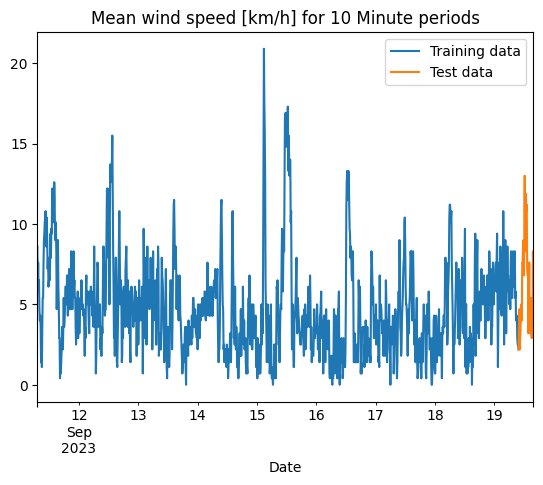

In [3]:
# Plot test and training data
# ======================================================================================
fig, ax=plt.subplots()
data_train.plot(ax=ax, label='Training data')
data_test.plot(ax=ax, label='Test data')
ax.set_title('Mean wind speed [km/h] for 10 Minute periods')
ax.legend();

In [4]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

print("Test stationarity for original series")
print("-------------------------------------")
adfuller_result = adfuller(data_station)
kpss_result = kpss(data_station)
print(f"ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}")
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

print("\nTest stationarity for differenced series (order=1)")
print("--------------------------------------------------")
data_diff_once = data_station.diff().dropna()
adfuller_result = adfuller(data_diff_once)
kpss_result = kpss(data_diff_once)
print(f"ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}")
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

print("\nTest stationarity for differenced series (order=2)")
print("--------------------------------------------------")
data_diff_twice = data_diff_once.diff().dropna()
adfuller_result = adfuller(data_diff_twice)
kpss_result = kpss(data_diff_twice)
print(f"ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}")
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

warnings.filterwarnings("default")

Test stationarity for original series
-------------------------------------
ADF Statistic: -9.29278574398513, p-value: 1.1675665645132535e-15
KPSS Statistic: 0.3338145341354841, p-value: 0.1

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -11.734706407048884, p-value: 1.3161623180470075e-21
KPSS Statistic: 0.01945672032758169, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -13.201366853901812, p-value: 1.0927529082556123e-24
KPSS Statistic: 0.20464573682665982, p-value: 0.1


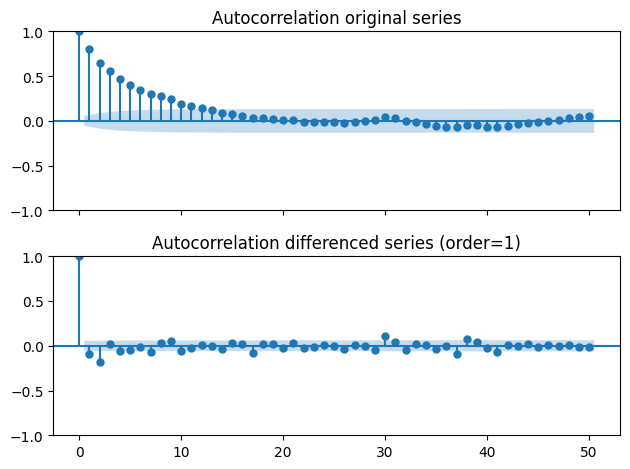

In [5]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_acf(data_station, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_once, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)')
plt.tight_layout();

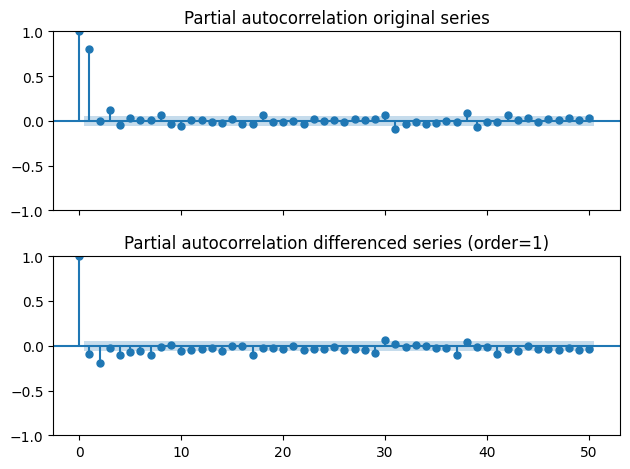

In [6]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_pacf(data_station, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title("Partial autocorrelation original series")
plot_pacf(data_diff_once, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title("Partial autocorrelation differenced series (order=1)")
plt.tight_layout();

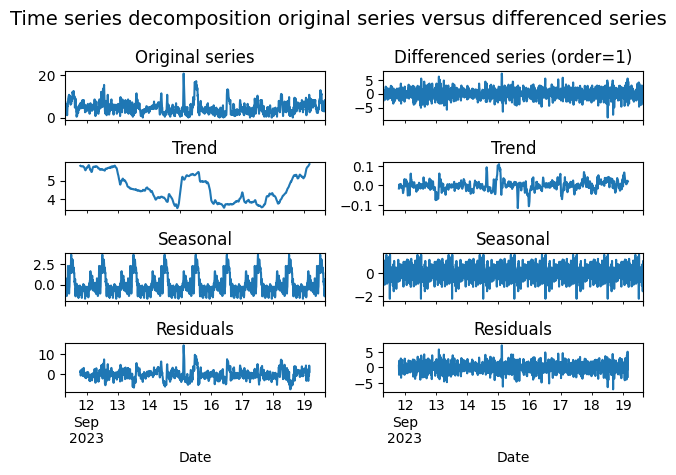

In [7]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data_station, model="additive", period=144)
res_descompose_diff_once = seasonal_decompose(data_diff_once, model="additive", period=144)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title("Original series")
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title("Trend")
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title("Seasonal")
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title("Residuals")

res_descompose_diff_once.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title("Differenced series (order=1)")
res_descompose_diff_once.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title("Trend")
res_descompose_diff_once.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title("Seasonal")
res_descompose_diff_once.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title("Residuals")
fig.suptitle(
    "Time series decomposition original series versus differenced series", fontsize=14
)

fig.tight_layout();

In [9]:
# ARIMA model training
# =============================================================================
model = SARIMAX(
    endog=data_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 144)
)
fitted = model.fit()
print(fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            fu3010z0   No. Observations:                 1169
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 144)   Log Likelihood               -2175.505
Date:                             Mon, 02 Oct 2023   AIC                           4361.010
Time:                                     11:58:31   BIC                           4385.667
Sample:                                 09-11-2023   HQIC                          4370.371
                                      - 09-19-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7821      0.019     41.514      0.000       0.745       0.819
ma.L1         -0.9924      

In [11]:
# ARIMA model prediction
# =============================================================================
predictions_train = fitted.predict(start=0, end=len(data_train) - 1)
predictions_test = fitted.predict(
    len(data_train) - 1, len(data_train) + len(data_test) - 2
)

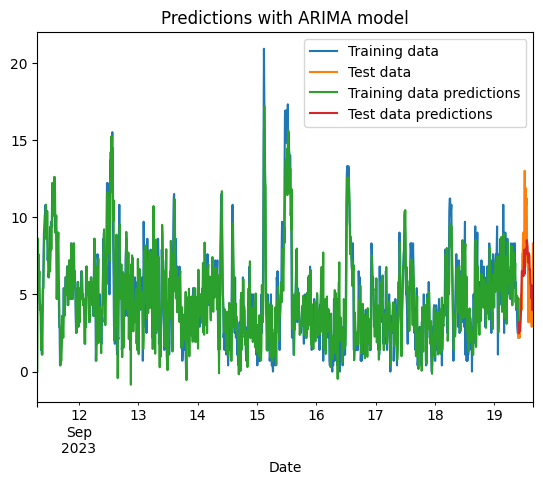

In [12]:
# Plot predictions
# =============================================================================
fig, ax = plt.subplots()
data_train.plot(ax=ax, label="Training data")
data_test.plot(ax=ax, label="Test data")
predictions_train.plot(ax=ax, label="Training data predictions")
predictions_test.plot(ax=ax, label="Test data predictions")
ax.set_title("Predictions with ARIMA model")
ax.legend();

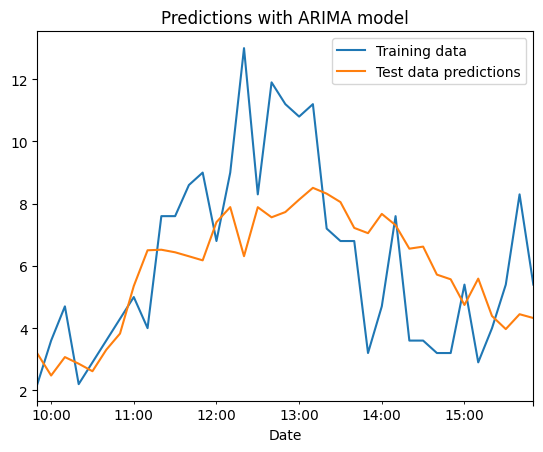

In [13]:
# Plot predictions of test data only
# =============================================================================
fig, ax = plt.subplots()
data_test.plot(ax=ax, label="Training data")
predictions_test.plot(ax=ax, label="Test data predictions")
ax.set_title("Predictions with ARIMA model")
ax.legend();


In [15]:
# Mean absolute error
# =============================================================================
metric = mean_absolute_error(predictions_train.to_numpy(), data_train.to_numpy())
print("Mean absolute error training data prediction: ", metric)

metric = mean_absolute_error(predictions_test.to_numpy(), data_test.to_numpy())
print("Mean absolute error test data prediction: ", metric)

Mean absolute error training data prediction:  1.5556319508865417
Mean absolute error test data prediction:  1.8516377107043283
